In [ ]:
# CNN Homework
# 2023-05-05
# Dataset: gropro
# net: Unet
# augmentation: yes


In [2]:
import torch
import cv2
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

import os
import torch.nn.functional as F
from torch.utils.data import Dataset

import random
import numpy as np
import json

from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [3]:
class Gopro_Loader(Dataset):
    def __init__(self, data_path, augmentation=False):
        self.data_path = data_path
        self.augmentation = augmentation
        self.imgs = glob.glob(os.path.join(data_path, 'blur/*.png'))

    def __getitem__(self, idx):
        # 讀取影像
        img_path = self.imgs[idx]
        label_path = img_path.replace("blur", "sharp")
        
        # 讀取標籤
        img = Image.open(img_path)
        label = Image.open(label_path)
        
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        if self.augmentation:
            # 固定隨機參數
            p1 = random.randint(0,1)
            p2 = random.randint(0,1)

            px = random.uniform(0,1)
            py = random.uniform(0,1)
            crop_size = (640, 368)
            
            def random_crop(img):
                x = (img.size[0]-crop_size[0])*px
                y = (img.size[1]-crop_size[1])*py
                return img.crop((x, y, x+crop_size[0], y+crop_size[1]))

            transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p1),
                transforms.RandomVerticalFlip(p2),
                transforms.Lambda(random_crop),
                transforms.ToTensor(),
            ])

        img = transform(img)
        label = transform(label)
        return img, label

    def __len__(self):
        return len(self.imgs)
    

In [4]:
class double_convolution(nn.Module):
    #(convolution => [BN] => ReLU) * 2
    def __init__(self, in_channels, out_channels):
        super(double_convolution,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)
    

class Down(nn.Module):
    #Downscaling with maxpool then double conv
    def __init__(self, in_channels, out_channels):
        super(Down,self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            double_convolution(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    #Upscaling then double conv
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = double_convolution(in_channels, out_channels)
        self.in_channels = in_channels

    def forward(self, x, x1):
        x = self.up(x)
        x1 = F.interpolate(x1, size=(x.size()[2], x.size()[3]))

        x = torch.cat([x1, x], dim=1)
        return self.conv(x)

In [5]:
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv_block = double_convolution(3, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.out = nn.Conv2d(64, 3, kernel_size=1, stride=1, padding=0)

        
    def forward(self, x):
#         print("x shape:", x.shape)
        
        x1 = self.conv_block(x)
#         print("x1 shape:", x1.shape)
        x2 = self.down1(x1)
#         print("x2 shape:", x2.shape)
        x3 = self.down2(x2)
#         print("x3 shape:", x3.shape)
        x4 = self.down3(x3)
#         print("x4 shape:", x4.shape)
        x5 = self.down4(x4)
#         print("x5 shape:", x5.shape)
        x = self.up1(x5, x4)
#         print("x shape:", x.shape)
        
        x = self.up2(x, x3)
#         print("x shape:", x.shape)
        x = self.up3(x, x2)
#         print("x shape:", x.shape)
        x = self.up4(x, x1)
#         print("x shape:", x.shape)
        x = self.out(x)
#         print("x shape:", x.shape)
        return x

In [6]:
def create_new_folder(path='.'):
    # 列出當前目錄下的所有資料夾
    folder_names = [name for name in os.listdir(path) if os.path.isdir(name)]
    
    # 找到最大的資料夾編號
    max_number = 1
    for name in folder_names:
        try:
            number = int(name.split("run")[1])
            if number > max_number:
                max_number = number
        except:
            pass

    # 創建新的資料夾
    new_folder_name = "run{:02d}".format(max_number + 1)
    os.mkdir(new_folder_name)
    print (f'create_new_folder {new_folder_name}')
    return new_folder_name

def save_metrics_to_json(metrics, filepath):
    with open(filepath, "w") as f:
        json.dump(metrics, f)
        
def plot_metrics(metrics, folder_path):
    accuracy = metrics["accuracy"]
    loss = metrics["loss"]
    
    epochs = range(1, len(accuracy) + 1)

    # 繪製 accuracy 與 loss 的趨勢圖
    plt.plot(epochs, accuracy, "b-", label="Training accuracy")
    plt.title("Training accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    plt.savefig(f"{folder_path}/train_acc.png")
    
    plt.plot(epochs, loss, "r-", label="Training loss")
    plt.title("Training loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    plt.savefig(f"{folder_path}/train_loss.png")

In [6]:
def train_net(net, train_loader, val_loader, num_epochs=10, learning_rate=0.001, device='cpu', save_mode="."):
    
    folder_path = create_new_folder(save_mode)
    
    # 将模型移动到指定设备
    net.to(device)
    
    # 定义损失函数和优化器
    criterion = MS_SSIM(data_range=1, size_average=True, channel=3).cuda() # channel=1 for grayscale images
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    best_loss = float('inf')
    loss_record = []
    acc_record = []
    
    # 训练模型
    for epoch in range(num_epochs):
        net.train() # 将模型设为训练模式
        train_loss = 0.0
        train_acc = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # 将梯度清零
            optimizer.zero_grad()
            
            # 前向传播，计算预测结果和损失
            outputs = net(inputs)
            loss = 1 - criterion(outputs, labels)
            
            # 保存loss值最小的网络参数
            if loss < best_loss:
                best_loss = loss
                torch.save(net.state_dict(), f'{folder_path}/best_model.pth')
            
            # 反向传播，更新参数
            loss.backward()
            optimizer.step()
            
            # 统计损失
            train_loss += loss.item()
            
            acc = ms_ssim(labels, outputs, data_range=1)
            train_acc += acc.item()
            
        torch.save(net.state_dict(), f'{folder_path}/epoch_{epoch}_model.pth')
        
        # 在验证集上测试模型，并记录损失
        net.eval() # 将模型设为测试模式
        val_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                
                # 前向传播，计算预测结果和损失
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                
                # 统计损失
                val_loss += loss.item()
                
        save_image(outputs, f'{folder_path}/epoch_{epoch}.png')
        # 打印每个epoch的损失
        average_train_loss = train_loss/len(train_loader)
        average_train_acc = train_acc/len(train_loader)
        average_val_loss = val_loss/len(val_loader)
        
        loss_record.append(average_train_loss)
        acc_record.append(average_train_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Val Loss: {average_val_loss}")
        
    metrics = {"accuracy": acc_record, "loss": loss_record}
    save_metrics_to_json(metrics, f'{folder_path}/metrics.json')
    plot_metrics(metrics, folder_path)
    
    return acc_record, loss_record, folder_path

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 2
net = UNet()

if torch.cuda.device_count() > 1:
    print ("multi GPUs")
    net = nn.DataParallel(net,device_ids = [0, 1])

train_data_path = "../../dataset_gopro/train"
train_dataset = Gopro_Loader(data_path=train_data_path, augmentation=True)
train_loader = torch.utils.data.DataLoader(
                                        dataset=train_dataset,
                                        batch_size=batch_size, 
                                        shuffle=True)
print (f'gopro dataset train size: {len(train_dataset)}')

eval_data_path = "../../dataset_gopro/eval"
eval_dataset = Gopro_Loader(data_path=eval_data_path, augmentation=False)
eval_loader = torch.utils.data.DataLoader(
                                        dataset=eval_dataset,
                                        batch_size=1, 
                                        shuffle=True)
print (f'gopro dataset test size: {len(eval_loader)}')

acc_record, loss_record, folder_path = train_net(
    net, train_loader, eval_loader, num_epochs=200, learning_rate=0.001, device=device)

multi GPUs
gopro dataset train size: 1603
gopro dataset test size: 200
create_new_folder run11


C:\Users\zhenRong\.conda\envs\yolov5\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Epoch 1/200, Train Loss: 0.2494642074565935, Val Loss: 0.8425090983510017
Epoch 2/200, Train Loss: 0.14268652102596444, Val Loss: 0.8342648354172707
Epoch 3/200, Train Loss: 0.13808000266106052, Val Loss: 0.8435205018520355
Epoch 4/200, Train Loss: 0.13613094727594657, Val Loss: 0.8430503132939339
Epoch 5/200, Train Loss: 0.13549098758923442, Val Loss: 0.8367551869153976
Epoch 6/200, Train Loss: 0.13499408551582376, Val Loss: 0.8457535746693611
Epoch 7/200, Train Loss: 0.13144594445787464, Val Loss: 0.8422377902269363
Epoch 8/200, Train Loss: 0.1301540806703734, Val Loss: 0.8448688212037087
Epoch 9/200, Train Loss: 0.12883967599666624, Val Loss: 0.8440592461824417
Epoch 10/200, Train Loss: 0.12670007058212585, Val Loss: 0.8489240247011185
Epoch 11/200, Train Loss: 0.125219514468067, Val Loss: 0.8420378422737121
Epoch 12/200, Train Loss: 0.12330602923236286, Val Loss: 0.8463202488422393
Epoch 13/200, Train Loss: 0.12427107109095985, Val Loss: 0.8449324363470078
Epoch 14/200, Train Loss:

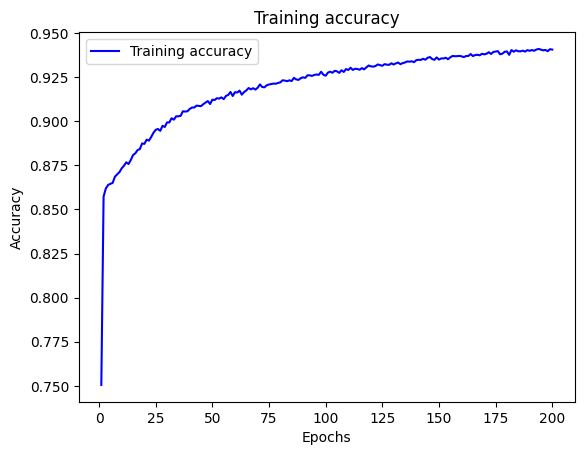

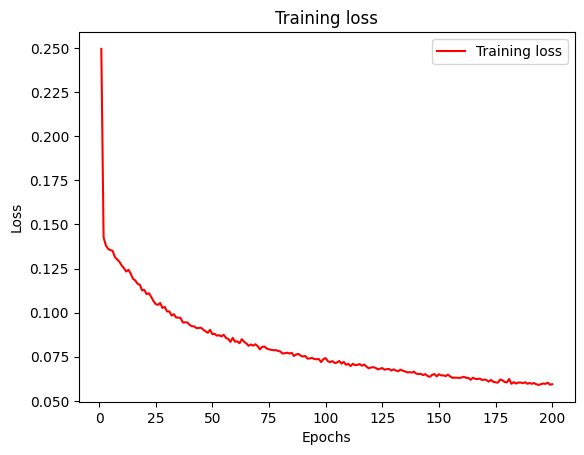

<Figure size 640x480 with 0 Axes>

In [13]:
with open('run11/metrics.json') as f:
    data = json.load(f)
plot_metrics(data, 'run11')

In [35]:
def test_model(net, device, test_loader, model_path, save_path):
    net.load_state_dict(torch.load(model_path, map_location=device))
    # 测试模式
    net.eval()
    criterion = MS_SSIM(data_range=1, size_average=True, channel=3).cuda() # reuse the gaussian kernel with SSIM & MS_SSIM.
    
    os.makedirs(save_path, exist_ok=True)
    
    count = 0
    for x, y in test_loader:
        x, y = x.to(device=device), y.to(device=device)
        with torch.no_grad():
            pred = net(x)
            save_image(pred, f'{save_path}/{count}.png')
        count += 1

In [38]:
net = UNet()
# 选择设备，有cuda用cuda，没有就用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.device_count() > 1:
    print ("multi GPUs")
    net = nn.DataParallel(net,device_ids = [0, 1])
net.to(device=device)

test_dataset = Gopro_Loader(data_path="../../dataset_gopro/test")
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
print (f'test data len: {len(test_dataset)}')

model_path = f'./run09/epoch_199_model.pth'
save_path = './run09/test_epoch_99'
test_model(net, device, test_loader, model_path, save_path)

multi GPUs
300


In [19]:
class Gopro_Loader(Dataset):
    def __init__(self, data_path, augmentation=False):
        self.data_path = data_path
        self.augmentation = augmentation
        self.imgs = glob.glob(os.path.join(data_path, 'blur/*.png'))

    def __getitem__(self, idx):
        # 讀取影像
        img_path = self.imgs[idx]
        label_path = img_path.replace("blur", "sharp")
        
        # 讀取標籤
        img = Image.open(img_path)
        label = Image.open(label_path)
        
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        if self.augmentation:
            # 固定隨機參數
            p1 = random.randint(0,1)
            p2 = random.randint(0,1)

            px = random.uniform(0,1)
            py = random.uniform(0,1)
            crop_size = (368, 640)
            
            def random_crop(img):
                x = (img.size[0]-crop_size[0])*px
                y = (img.size[1]-crop_size[1])*py
                return img.crop((x, y, x+crop_size[0], y+crop_size[1]))

            transform = transforms.Compose([
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomVerticalFlip(0.5),
                transforms.RandomCrop(size=(crop_size)),
                transforms.ToTensor(),
            ])

        img = transform(img)
        label = transform(label)
        return img, label

    def __len__(self):
        return len(self.imgs)
    

数据个数： 1603


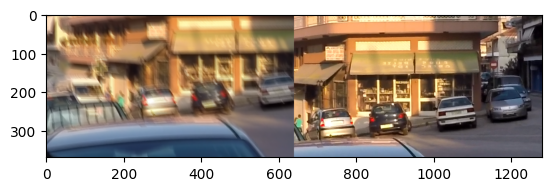

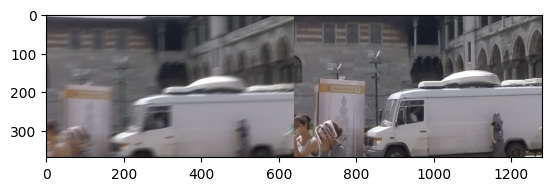

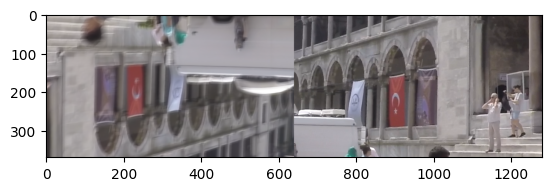

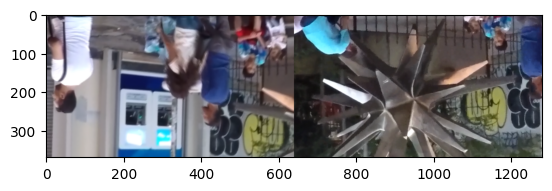

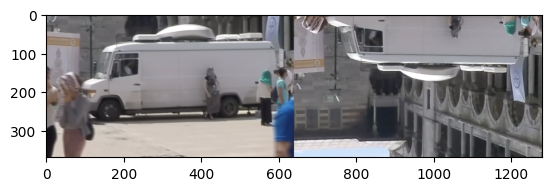

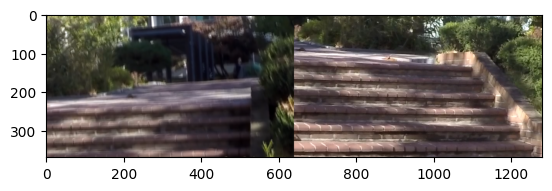

In [24]:
train_dataset = Gopro_Loader(data_path="../../dataset_gopro/train", augmentation=True)
print("数据个数：", len(train_dataset))

train_loader = torch.utils.data.DataLoader(
                                    dataset=train_dataset,
                                    batch_size=1, 
                                    shuffle=True)

for i, data in enumerate(train_loader):
    if i > 5:
        break
    iamge = data[0][0].numpy().transpose(1, 2, 0)
    label = data[1][0].numpy().transpose(1, 2, 0)
    merged_image = np.concatenate((iamge, label), axis=1)
    
    plt.imshow(merged_image)
    plt.show()